In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [24]:
df = pd.read_csv("shampoo.csv", index_col=0)


def build_lstm_dataset(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df 

df2 = build_lstm_dataset(df, lag=2)
df2.head()

,Sales,Sales,Sales
Month,,,
1-01,0.0,0.0,266.0
1-02,266.0,0.0,145.9
1-03,145.9,266.0,183.1
1-04,183.1,145.9,119.3
1-05,119.3,183.1,180.3


In [70]:
def difference(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def invert_scale(scaler, x, yhat):
    row = [xi for xi in x] + [yhat]
    row = np.asarray(row)
    row = row.reshape(1, len(row))
    inverted = scaler.inverse_transform(row)
    return inverted[0, 1]

<Figure size 1080x1080 with 0 Axes>

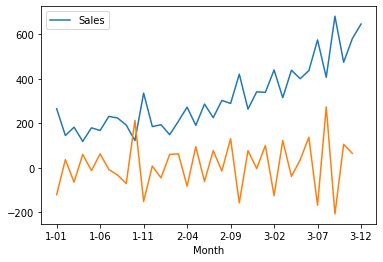

In [26]:
df3 = difference(df.values, 1)
_ = plt.figure(figsize=(15, 15))
df.plot()
df3.plot()
plt.show()

<AxesSubplot:>

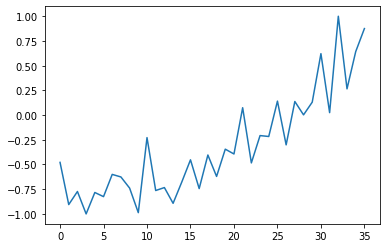

In [33]:
from sklearn.preprocessing import MinMaxScaler

X = df.values
X = X.reshape(len(X), 1)
sc = MinMaxScaler(feature_range=(-1, 1))
sc.fit(X)
X_sc = sc.transform(X)

df4 = pd.Series(X_sc[:, 0])
df4.plot()


In [42]:
# load data
sales = pd.read_csv("shampoo.csv", header=0, index_col=0)

# convert to array 
raw_values = sales.values 

# make stationary (df/dt)
diff_values = difference(raw_values, 1)

# build series for training an lstm 
lstm_series = build_lstm_dataset(diff_values, 1)

# convert to array 
lstm_values = lstm_series.values 


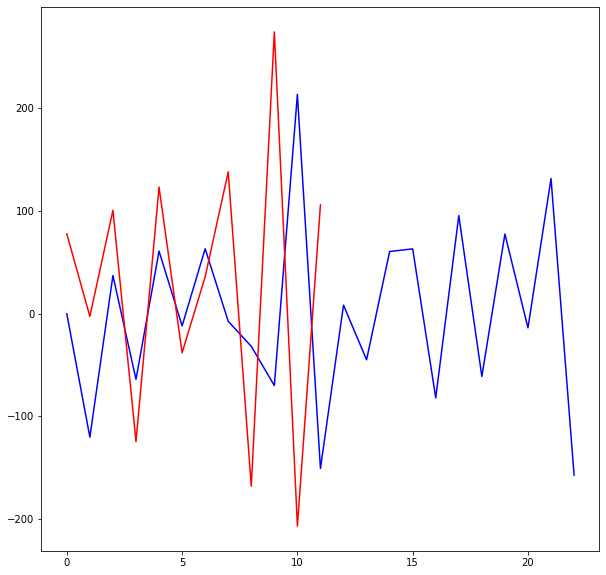

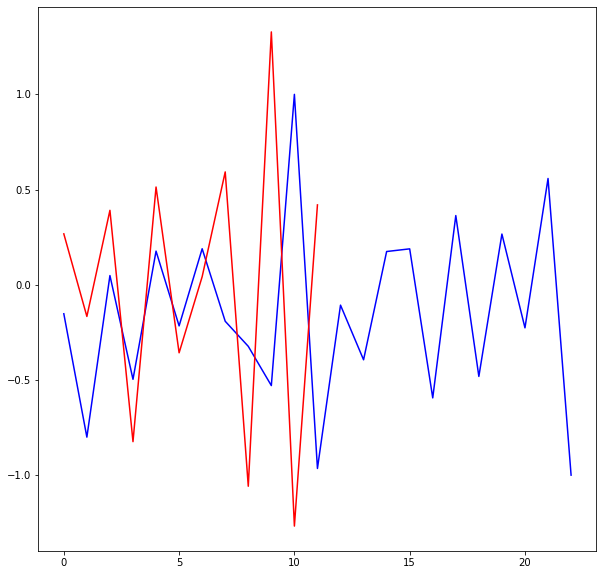

In [44]:
# get train, test data 
train, test = lstm_values[:-12], lstm_values[-12:]

# scale train, test between -1 and 1
# initialise a MinMaxScaler
sc = MinMaxScaler(feature_range=(-1, 1))

# fit a scaler
sc = sc.fit(train)

# transform train data
train = train.reshape(train.shape[0], train.shape[1])
train_scaled = sc.transform(train)

# transform test data 
test = test.reshape(test.shape[0], test.shape[1])
test_scaled = sc.transform(test)

# plot raw data
_ = plt.figure(figsize=(10, 10))
plt.plot(range(0, train.shape[0]), train[:, 0], 'b')
plt.plot(range(0, test.shape[0]), test[:, 0], 'r')
plt.show()

# plot scaled data
_ = plt.figure(figsize=(10, 10))
plt.plot(range(0, train_scaled.shape[0]), train_scaled[:, 0], 'b')
plt.plot(range(0, test_scaled.shape[0]), test_scaled[:, 0], 'r')
plt.show()

In [73]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

batch_size = 1
X = train_scaled[:, 0:-1]
y = train_scaled[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

epochs = 1000
for i in range(epochs):
    model.fit(X, y, epochs=1, batch_size=batch_size)
    model.reset_states()

predictions = []
rescaled_predictions = []
real = []
for i in range(len(test_scaled)):
    X_test, y_test = test_scaled[i, 0:-1], test_scaled[i, :-1]
    X_test = X_test.reshape(1, 1, len(X_test))
    y_pred = model.predict(X_test, batch_size=1)
    y_hat = invert_scale(sc, X_test, y_pred)
    y_pred = y_pred[0, 0]    
    predictions.append(y_pred)
    rescaled_predictions.append(y_hat)
    real.append(y_test[0])

 1ms/step - loss: 0.1249
23/23 [==============================] - 0s 1ms/step - loss: 0.1336


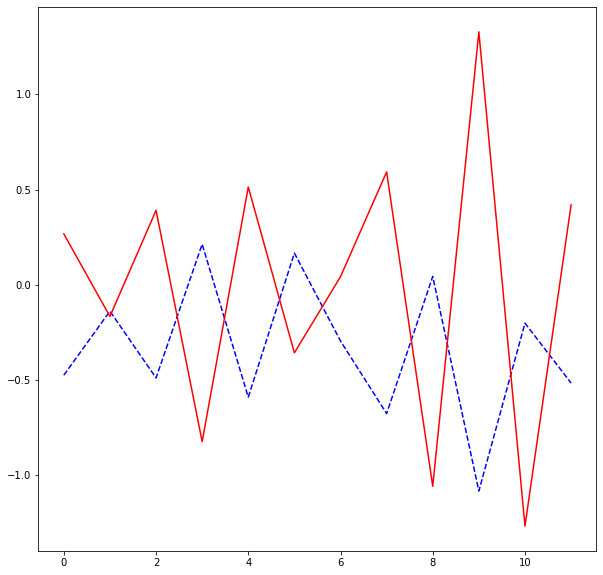

In [62]:
_ = plt.figure(figsize=(10, 10))
plt.plot(predictions, "b--")
plt.plot(real, 'r')
plt.show()

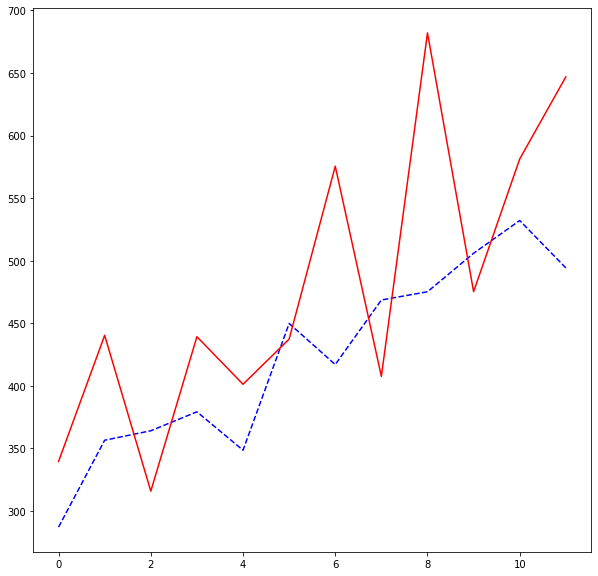

In [82]:
# Plot real values and converted predicted values on the same axis
predicticted = []
for i in range(len(test_scaled)):
    y_hat = inverse_difference(raw_values, rescaled_predictions[i], len(test_scaled)+1-i)
    predicticted.append(y_hat)

_ = plt.figure(figsize=(10, 10))
plt.plot(predicticted, "b--")
plt.plot(raw_values[-12:], 'r')
plt.show()